# 🧠 Agrupamiento de Pokémon con K-Means
Análisis de las estadísticas de batalla de Pokémon para descubrir perfiles de combate mediante técnicas de Machine Learning.


## 📚 Introducción

El objetivo de este proyecto es agrupar Pokémon según sus estadísticas de batalla (HP, Attack, Defense, Sp. Atk, Sp. Def, Speed) utilizando el algoritmo de clustering K-Means. Este análisis permitirá descubrir perfiles de Pokémon con características similares que podrían ser útiles para estrategias de juego, merchandising, o balanceo de equipos.

---


In [3]:
import sys
from pathlib import Path

# Agregar src/ al path
sys.path.append(str(Path().resolve().parent))

# Importar la función desde tu visual (src/clustering/kmeans.py)
from src.clustering.kmeans import find_optimal_k, fit_kmeans 
from src.data.load_data import load_raw_pokemon


# 📦 Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



| Librería                       | ¿Para qué la usamos?                            |
| ------------------------------ | ----------------------------------------------- |
| `sys`, `pathlib.Path`          | Modificar el sistema de rutas de Python.        |
| `pandas`                       | Cargar y manipular datos tipo tabla.            |
| `numpy`                        | Cálculo numérico eficiente.                     |
| `matplotlib.pyplot`            | Gráficos básicos (codo, scatter, etc).          |
| `seaborn`                      | Gráficos mejorados con colores y temas.         |
| `StandardScaler` (`sklearn`)   | Escalar datos (media 0, varianza 1).            |
| `PCA` (`sklearn`)              | Reducción de dimensiones (visualizar clusters). |
| `KMeans` (`sklearn`)           | Algoritmo de clustering K-Means.                |
| `silhouette_score` (`sklearn`) | Validar calidad de los clusters.                |


## 📥 Cargar Datos

Cargamos el dataset de Pokémon.

In [6]:
# Carga y preprocesamiento básico
df = load_raw_pokemon("Pokemon.csv")
df.head()
# Mostramos las primeras filas para entender la estructura de los datos

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## 🎯 Selección de Características

Seleccionamos las estadísticas numéricas de interés para el análisis de clustering.


In [7]:
# Selección de estadísticas base
num_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"] # Estas estadísticas serán las que usaremos para agrupar los Pokémon
X = df[num_cols].values



## ⚙️ Normalización de Datos

Aplicamos StandardScaler para estandarizar los datos (media=0, varianza=1).


In [8]:
# Escalado/Normalizacion
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X)
# Esto es importante porque K-Means es sensible a la escala de las variables

## 🔍 Evaluación del Número Óptimo de Clusters

Para determinar el número óptimo de clusters (`k`), aplicamos dos métodos:

### 📉 Método del Codo
El método del codo evalúa cómo varía la **inercia** (suma de las distancias cuadradas de los puntos a sus centroides) a medida que aumenta el número de clusters. Buscamos el punto donde agregar más clusters ya no disminuye significativamente la inercia — el "codo" del gráfico.

### 📈 Silhouette Score
El **silhouette score** mide la calidad del clustering:
- Valores cercanos a 1 indican clusters bien definidos y separados.
- Valores cercanos a 0 indican clusters solapados.
- Valores negativos indican que los puntos están en el cluster equivocado.

### 📊 Gráfico combinado
A continuación se muestra un gráfico doble:
- **Curva azul**: Inercia vs. número de clusters.
- **Curva naranja**: Silhouette score vs. número de clusters.

Este gráfico nos ayuda a identificar visualmente el número óptimo de clusters balanceando compactación (**inercia**) y separación (**silhouette**).


,k,inertia,silhouette
0,2,3275.381233,0.288577
1,3,2893.231116,0.225192
2,4,2573.390931,0.225795
3,5,2373.476430,0.221723
4,6,2275.774303,0.164028
5,7,2069.039260,0.169783
6,8,1976.473350,0.160074
7,9,1898.418210,0.158191
8,10,1797.965179,0.162067


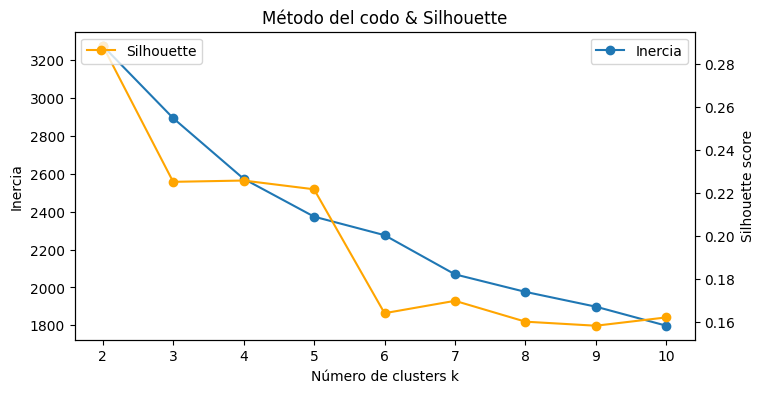

In [9]:
# Prueba k=2..10
results = find_optimal_k(X_scaled, k_range=range(2,11))

# Mostrar la tabla
display(results)

# Plot
fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.plot(results["k"], results["inertia"], marker="o", label="Inercia")
ax2.plot(results["k"], results["silhouette"], marker="o", color="orange", label="Silhouette")

ax1.set_xlabel("Número de clusters k")
ax1.set_ylabel("Inercia")
ax2.set_ylabel("Silhouette score")
ax1.set_xticks(results["k"])
ax1.legend(loc="upper right")
ax2.legend(loc="upper left")
plt.title("Método del codo & Silhouette")
#La inercia (qué tan compactos son los clusters).
#El silhouette score (qué tan bien separados están los clusters).
plt.show()


## 🏷️ Aplicación Final de K-Means y Análisis de Clusters

Aplicamos el algoritmo de K-Means usando el número óptimo de clusters identificado previamente (`k=4`).

### 📌 Asignación de Clusters
Cada Pokémon es asignado a uno de los 4 clusters basándose en sus estadísticas normalizadas.

### 📊 Distribución de Pokémon por Cluster
Contamos cuántos Pokémon pertenecen a cada cluster para analizar el tamaño y balance de los grupos.

### 🧩 Interpretación de los Clusters
Calculamos los centroides (valores promedio) de cada cluster, revirtiendo la normalización para interpretar los resultados en escala original (HP, Attack, Defense, etc.).

Este análisis permite entender los perfiles promedio de cada grupo de Pokémon.


In [10]:
# Por ejemplo k=4
k_opt = 4
km_model = fit_kmeans(X_scaled, n_clusters=k_opt)

# Añadimos la etiqueta al DataFrame
df["cluster"] = km_model.labels_

# Vemos distribución de tamaños
print(df["cluster"].value_counts().sort_index())

# Inspeccionamos centroides en escala original
centroids = scaler.inverse_transform(km_model.cluster_centers_)
cent_df = pd.DataFrame(centroids, columns=num_cols)
display(cent_df)


cluster
0    283
1    202
2    115
3    200
Name: count, dtype: int64


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,50.113074,53.975265,51.890459,48.060071,49.212014,49.452297
1,69.287129,84.306931,65.910891,83.524752,73.039604,94.623762
2,94.304348,114.017391,94.565217,117.652174,103.686957,95.452174
3,81.920000,88.920000,101.000000,71.265000,84.585000,52.680000


## 🧠 Reducción de Dimensionalidad y Visualización de Clusters

### 📉 Reducción de Dimensionalidad con PCA

Aplicamos **PCA** (Análisis de Componentes Principales) para reducir las 6 estadísticas de los Pokémon (`HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, `Speed`) a solo 2 dimensiones (`PCA1` y `PCA2`).

Este proceso mantiene la máxima varianza posible en el menor número de dimensiones, permitiendo visualizar los datos en 2D de manera efectiva.

### 📊 Visualización de Clusters en 2D

Utilizando las componentes principales obtenidas (`PCA1`, `PCA2`), graficamos cada Pokémon en un plano bidimensional, coloreado según su cluster asignado por K-Means.

Esto nos permite observar visualmente cómo se agrupan los Pokémon y evaluar la separación entre clusters.


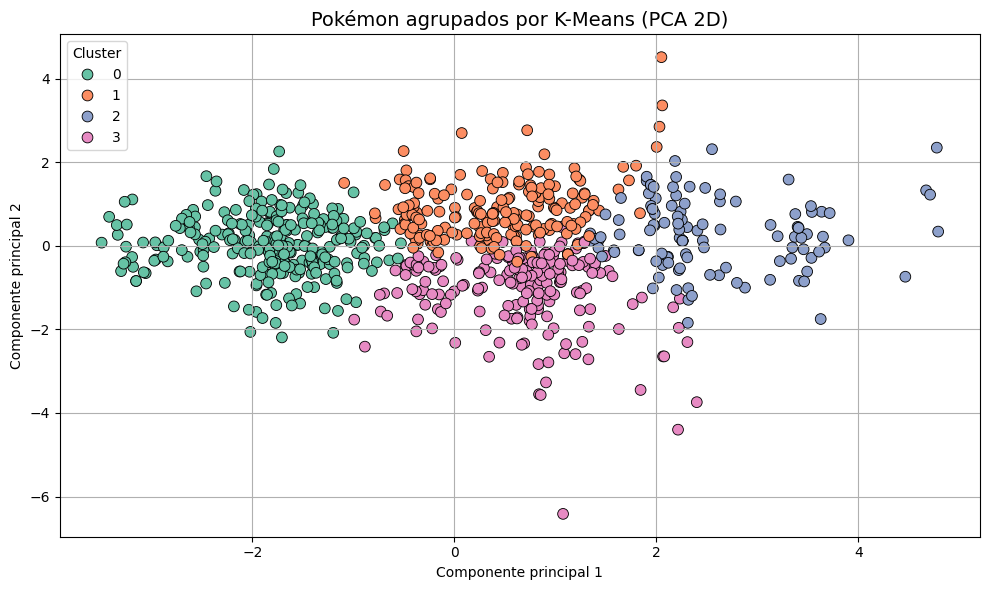

In [11]:

# Aplicamos PCA a los datos ya escalados
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Añadimos al dataframe para graficar Aplicas PCA para proyectar a 2D.

df["PCA1"] = X_pca[:, 0]
df["PCA2"] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x="PCA1", y="PCA2",
    hue="cluster",
    palette="Set2",
    s=60,
    edgecolor="black"
)

plt.title("Pokémon agrupados por K-Means (PCA 2D)", fontsize=14)
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


## 📊 Análisis Estadístico de Clusters

Después de aplicar K-Means y visualizar los clusters en 2D con PCA, realizamos un análisis estadístico para interpretar los grupos.

Agrupamos los Pokémon por su `cluster` y calculamos el promedio de sus estadísticas (`HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, `Speed`).

Esto nos permite comprender el perfil típico de cada cluster y asignar nombres o descripciones basadas en las características promedio de sus miembros.


In [12]:
# Agrupar por cluster y obtener promedios
cluster_means = df.groupby("cluster")[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].mean().round(1)
display(cluster_means)


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
cluster,,,,,,
0,50.1,54.0,51.9,48.1,49.2,49.5
1,69.3,84.3,65.9,83.5,73.0,94.6
2,94.3,114.0,94.6,117.7,103.7,95.5
3,81.9,88.9,101.0,71.3,84.6,52.7


## 📊 Visualización de Perfiles Promedio por Cluster
Para interpretar fácilmente los perfiles estadísticos promedio de cada cluster, graficamos un **heatmap**.
La intensidad de color ayuda a visualizar qué atributos destacan en cada grupo.


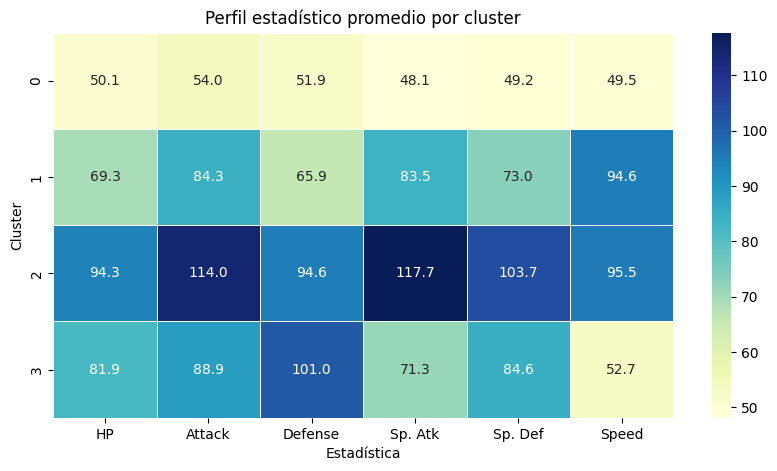

In [13]:
# Graficar heatmap de los promedios
plt.figure(figsize=(10, 5))
sns.heatmap(cluster_means, annot=True, cmap="YlGnBu", fmt=".1f", linewidths=0.5)
plt.title("Perfil estadístico promedio por cluster")
plt.ylabel("Cluster")
plt.xlabel("Estadística")
plt.show()

In [14]:
cluster_nombres = {
    0: "Básico",
    1: "Relámpagos Letales",
    2: "Élite Inalcanzable",
    3: "Murallas Eternas"
}


## 🌌 Visualización Avanzada: Clusters en 3D Interactivo
Luego, utilizando **Plotly**, graficamos estos datos en un espacio 3D donde:


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Escalar los datos antes del PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[num_cols])

# Aplicar PCA sobre los datos escalados
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_scaled)

# Agregar componentes al DataFrame
df['PCA1'] = pca_result[:, 0]
df['PCA2'] = pca_result[:, 1]
df['PCA3'] = pca_result[:, 2]
df['Nombre Cluster'] = df['cluster'].map(cluster_nombres)

# Graficar
fig = px.scatter_3d(
    df,
    x='PCA1', y='PCA2', z='PCA3',
    color='Nombre Cluster',
    hover_name='Name',
    hover_data=['Type 1', 'HP', 'Attack', 'Speed'],
    opacity=0.85,
    title="Agrupación de Pokémon por estilo de combate (PCA 3D interactivo)"
)


fig.show()



In [20]:
cluster_stats = df.groupby("cluster")[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].mean()


In [21]:
cluster_stats = df.groupby("cluster")[num_cols].mean()


## 🕸️ Visualización de Perfiles Promedio: Radar Charts

Para entender mejor los perfiles estadísticos promedio de cada cluster, utilizamos **Radar Charts**.

Cada radar chart muestra:
- Las estadísticas promedio (`HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, `Speed`) de los Pokémon en cada grupo.
- Los gráficos están normalizados a la misma escala (0 a 120) para facilitar la comparación visual.


---


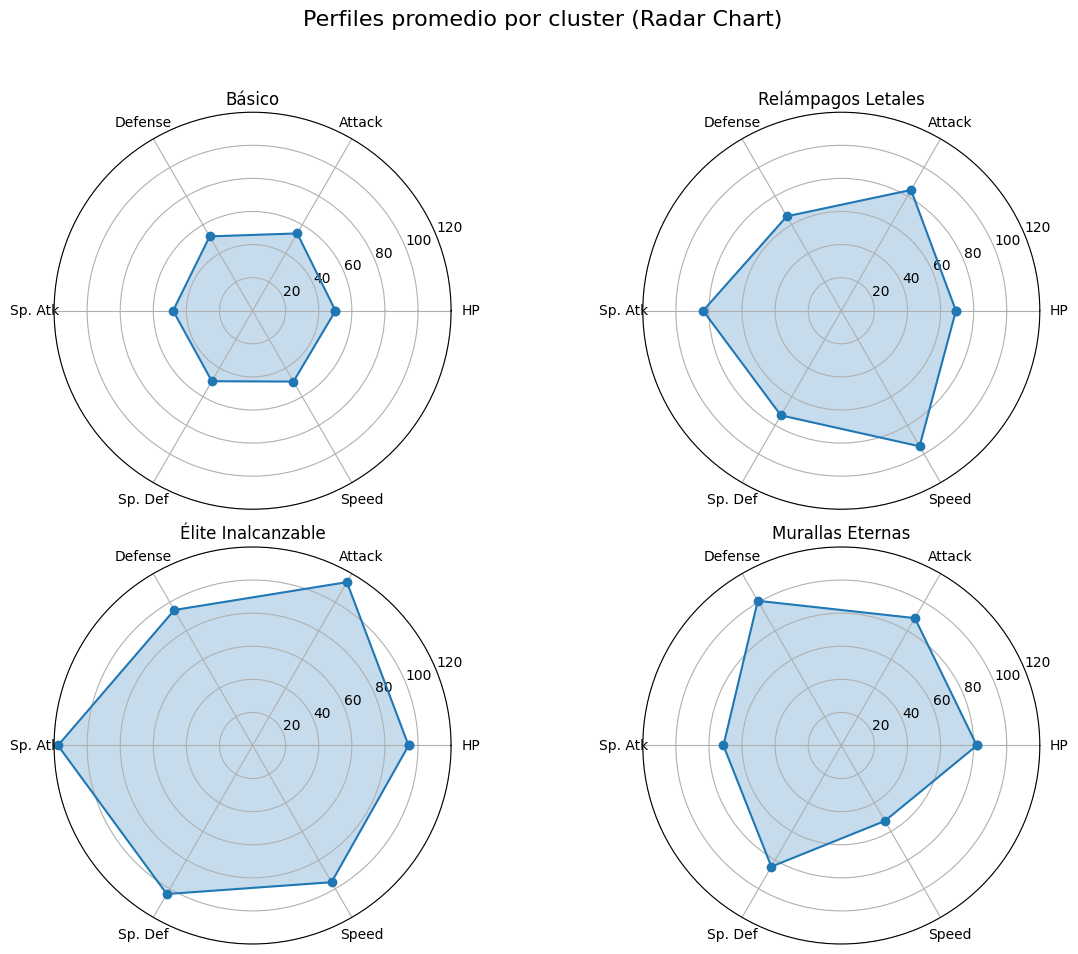

In [22]:
import matplotlib.pyplot as plt
import numpy as np

stats = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
cluster_nombres = {
    0: "Básico",
    1: "Relámpagos Letales",
    2: "Élite Inalcanzable",
    3: "Murallas Eternas"
}

fig, axs = plt.subplots(2, 2, figsize=(12, 10), subplot_kw=dict(polar=True))
fig.suptitle("Perfiles promedio por cluster (Radar Chart)", fontsize=16)

for ax, (i, row) in zip(axs.flat, cluster_stats.iterrows()):
    values = row[stats].tolist()
    values += values[:1]

    angles = np.linspace(0, 2 * np.pi, len(stats), endpoint=False).tolist()
    angles += angles[:1]

    ax.plot(angles, values, marker='o')
    ax.fill(angles, values, alpha=0.25)
    ax.set_ylim(0, 120)
    ax.set_thetagrids(np.degrees(angles[:-1]), stats)
    ax.set_title(cluster_nombres[i], size=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 🕸️ Comparación Global de Perfiles: Radar Chart Combinado

Para comparar directamente los perfiles promedio de todos los clusters, graficamos un **Radar Chart combinado**.

Cada línea representa un cluster con su nombre descriptivo:

- **Básico**
- **Relámpagos Letales**
- **Élite Inalcanzable**
- **Murallas Eternas**

Esta visualización facilita la comparación simultánea de todas las estadísticas (`HP`, `Attack`, `Defense`, `Sp. Atk`, `Sp. Def`, `Speed`) entre los diferentes estilos de combate.


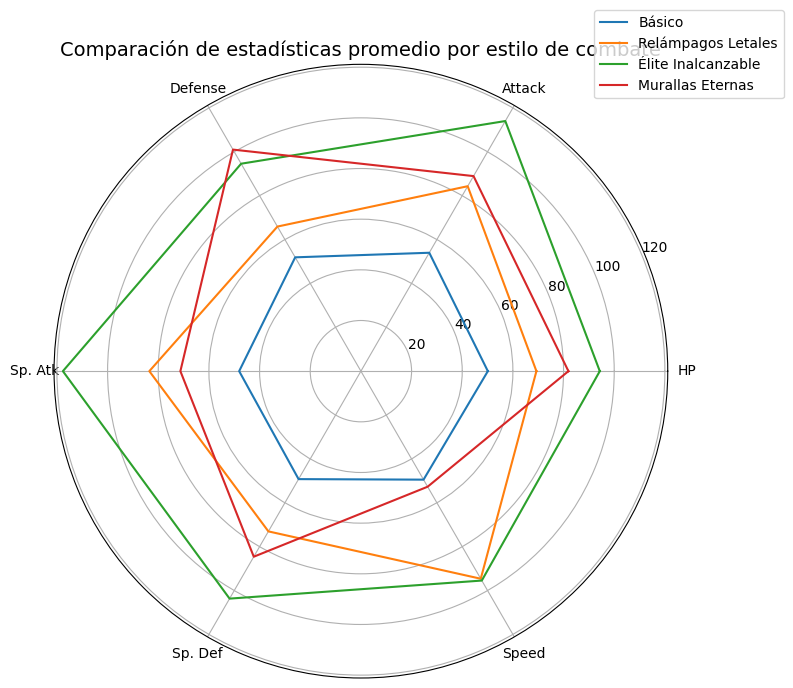

In [27]:
# Preparar gráfico
# Define las estadísticas que estás usando como labels
labels = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
plt.figure(figsize=(8, 8))
for i, fila in cluster_stats.iterrows():
    valores = fila.tolist()
    valores += valores[:1]  # cerrar el círculo
    plt.polar(angles, valores, label=cluster_nombres[i])

plt.title("Comparación de estadísticas promedio por estilo de combate", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.xticks(angles[:-1], labels)  # ← corregido aquí
plt.tight_layout()
plt.show()



- 🔵 **Cluster 0 – Básico**: Equilibrados. Para aprender jugando.
- 🟣 **Cluster 1 – Relámpagos Letales**: Veloz y agresivo.
- 🔴 **Cluster 2 Élite Inalcanzable**: Stats perfectos. Para competir.
- 🟢 **Cluster 3  Murallas Eternas**: Mucha defensa. Para resistir y planear.


## 🔍 Ejemplos de Pokémon por Estilo de Combate

Asignamos a cada Pokémon un perfil basado en su cluster, utilizando nombres descriptivos:

- **Básico**
- **Relámpagos Letales**
- **Élite Inalcanzable**
- **Murallas Eternas**

A continuación, mostramos ejemplos de Pokémon representativos de cada perfil, junto con sus estadísticas principales de combate.

In [25]:
df["perfil"] = df["cluster"].map(cluster_nombres)
for i in range(4):
    print(f"\n🌟 {cluster_nombres[i]}")
    display(df[df["cluster"] == i][["Name", "perfil", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]].head(5))
    



🌟 Básico


,Name,perfil,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Básico,45,49,49,65,65,45
4,Charmander,Básico,39,52,43,60,50,65
9,Squirtle,Básico,44,48,65,50,64,43
13,Caterpie,Básico,45,30,35,20,20,45
14,Metapod,Básico,50,20,55,25,25,30



🌟 Relámpagos Letales


,Name,perfil,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
1,Ivysaur,Relámpagos Letales,60,62,63,80,80,60
2,Venusaur,Relámpagos Letales,80,82,83,100,100,80
5,Charmeleon,Relámpagos Letales,58,64,58,80,65,80
6,Charizard,Relámpagos Letales,78,84,78,109,85,100
15,Butterfree,Relámpagos Letales,60,45,50,90,80,70



🌟 Élite Inalcanzable


,Name,perfil,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
3,VenusaurMega Venusaur,Élite Inalcanzable,80,100,123,122,120,80
7,CharizardMega Charizard X,Élite Inalcanzable,78,130,111,130,85,100
8,CharizardMega Charizard Y,Élite Inalcanzable,78,104,78,159,115,100
12,BlastoiseMega Blastoise,Élite Inalcanzable,79,103,120,135,115,78
23,PidgeotMega Pidgeot,Élite Inalcanzable,83,80,80,135,80,121



🌟 Murallas Eternas


,Name,perfil,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
10,Wartortle,Murallas Eternas,59,63,80,65,80,58
11,Blastoise,Murallas Eternas,79,83,100,85,105,78
33,Sandslash,Murallas Eternas,75,100,110,45,55,65
36,Nidoqueen,Murallas Eternas,90,92,87,75,85,76
41,Clefable,Murallas Eternas,95,70,73,95,90,60


## 📊 Tabla de Perfiles y Estadísticas Promedio

Según tus respuestas en el test, tu perfil de combate es:

| Perfil                  | Descripción                                                                  | HP   | Attack | Defense | Sp. Atk | Sp. Def | Speed |
|--------------------------|-----------------------------------------------------------------------------|------|--------|---------|---------|---------|-------|
| **Básico**               | Balance total, ideal para quienes buscan un desafío justo y estratégico.    | 50.1 | 54.0   | 51.9    | 48.1    | 49.2    | 49.5  |
| **Relámpagos Letales**    | Alta velocidad y ataque. Ideal para jugadores ofensivos e impulsivos.       | 69.3 | 84.3   | 65.9    | 83.5    | 73.0    | 94.6  |
| **Élite Inalcanzable**    | Stats elevados en todo. Para los que buscan la supremacía total.            | 94.3 | 114.0  | 94.6    | 117.7   | 103.7   | 95.5  |
| **Murallas Eternas**      | Defensa sólida y resistencia. Perfecto para estrategas pacientes.           | 81.9 | 88.9   | 101.0   | 71.3    | 84.6    | 52.7  |

---

💡 **Tip**: Si quieres un equipo que juegue a tu estilo natural, busca Pokémon que pertenezcan a este perfil.


📝 Test: ¿Qué Estilo de Combate Pokémon Va Más Contigo?
Instrucciones:
Responde sinceramente a las siguientes preguntas. Suma el total de puntos por cada respuesta y al final verás qué perfil es el más compatible contigo.

Cada opción A, B, C, D estará asociada a un perfil:

A → Básico

B → Relámpagos Letales

C → Élite Inalcanzable

D → Murallas Eternas

1. ¿Cómo prefieres que sea un combate?
A) Que sea equilibrado, donde la estrategia sea clave.

B) Rápido y agresivo, atacar antes que el rival.

C) Dominar en todos los aspectos, tener poder absoluto.

D) Resistir todo lo que me lancen y ganar por desgaste.

2. ¿Qué te gusta más en un equipo Pokémon?
A) Que todos sean balanceados en ataque, defensa y velocidad.

B) Pokémon veloces y fuertes, aunque sean frágiles.

C) Pokémon legendarios o de stats muy altos.

D) Pokémon con alta defensa y resistencia.

3. ¿Cuál es tu actitud al enfrentar desafíos?
A) Me gustan los retos justos, ni muy fáciles ni imposibles.

B) Prefiero atacar primero, pensar después.

C) Busco ser invencible, prefiero el poder absoluto.

D) Soy paciente y prefiero resistir, sé que ganaré a largo plazo.

4. ¿Qué valoras más en un Pokémon?
A) Versatilidad: que pueda adaptarse a diferentes situaciones.

B) Velocidad: que siempre golpee primero.

C) Poder global: que sea bueno en todo.

D) Defensa: que pueda soportarlo todo y desgastar al rival.

5. ¿Qué dificultad prefieres en los juegos?
A) Me gusta la dificultad justa, que me haga pensar pero no frustrarme.

B) Prefiero que el juego sea dinámico y de acción rápida.

C) Me gustan los retos difíciles y vencerlos con supremacía.

D) Prefiero juegos donde la estrategia lenta y la paciencia sean la clave

## 🧠 Conclusiones y análisis por perfil de jugador

A través del algoritmo de K-Means y el análisis de estadísticas de batalla, agrupamos a los Pokémon en cuatro perfiles distintos:

- **Básico**  
  Ideal para jugadores principiantes. Son Pokémon balanceados con estadísticas moderadas y comportamiento estable.

- **Relámpagos Letales**  
  Pensado para quienes disfrutan atacar primero. Alta velocidad y ataque físico o especial. Perfectos para estrategias ofensivas rápidas.

- **Élite Inalcanzable**  
  Alto rendimiento en todas las estadísticas. Ideal para jugadores experimentados que buscan una ventaja global y equipos bien balanceados.

- **Murallas Eternas**  
  Pokémon que resisten muchos turnos. Altísima defensa y defensa especial, recomendados para jugadores que disfrutan estrategias a largo plazo.

Estos perfiles permiten orientar al jugador hacia un equipo acorde a su estilo de juego.

---


📊 Precisión del Árbol de Decisión: 0.87
🔮 El nuevo Pokémon sería clasificado en el cluster: 1


C:\dev\pokeMeans\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names



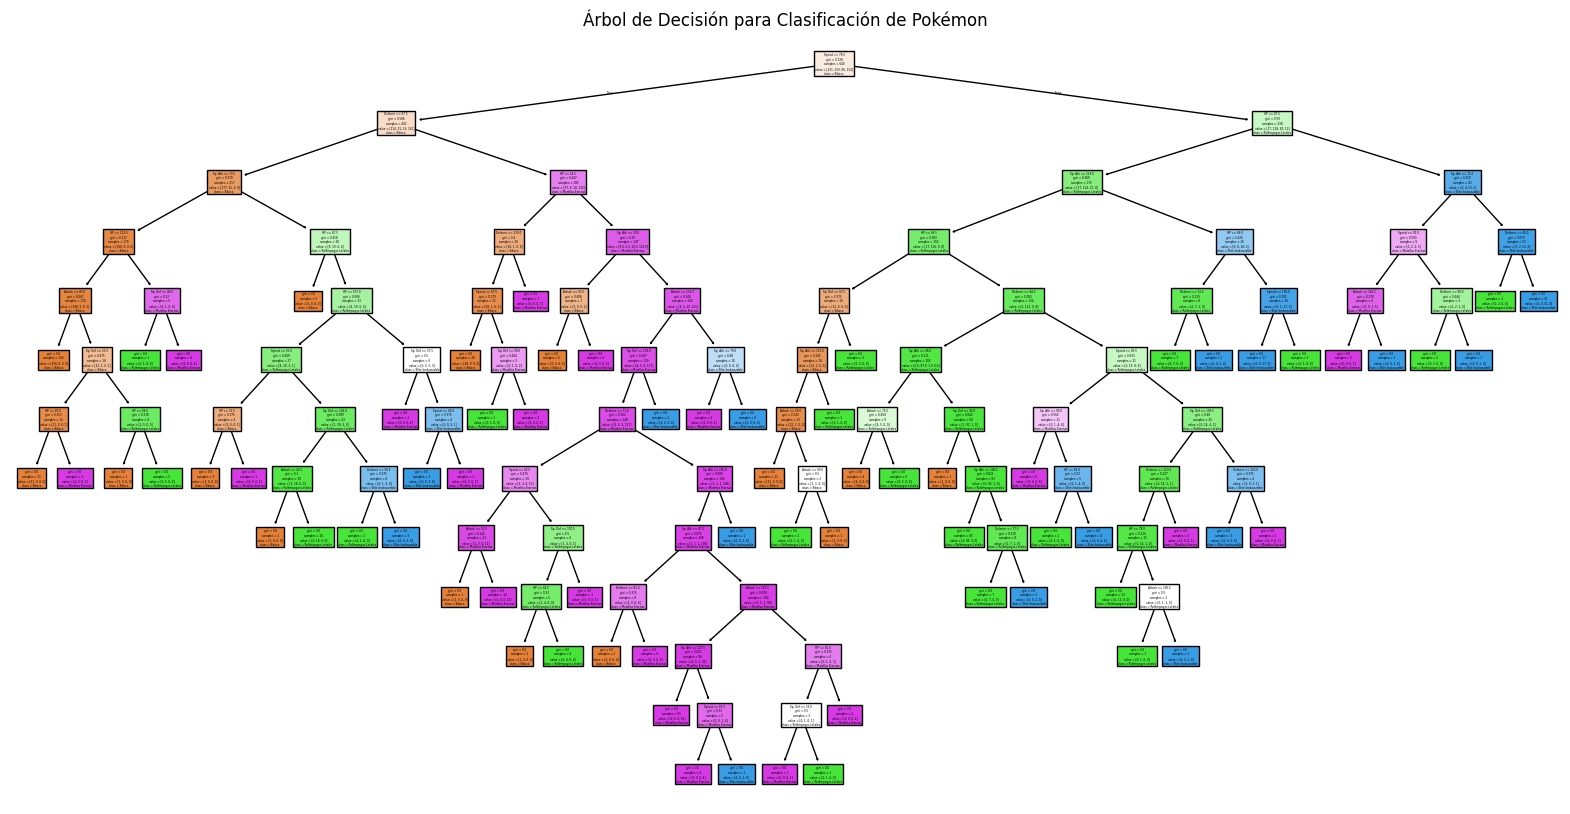

In [28]:
# ========================
# 📚 Clasificación Supervisada con Árbol de Decisión
# ========================

# 1. Importaciones necesarias
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

# 2. Preparar los datos
# Variables independientes
X = df[["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]]

# Variable dependiente (lo que queremos predecir)
y = df["cluster"]

# 3. Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Crear y entrenar el Árbol de Decisión
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

# 5. Evaluar el modelo
accuracy = modelo_arbol.score(X_test, y_test)
print(f"📊 Precisión del Árbol de Decisión: {accuracy:.2f}")

# 6. Predecir un nuevo Pokémon
# Ejemplo: Pokémon con estadísticas personalizadas
nuevo_pokemon = [[80, 100, 70, 90, 80, 95]]
cluster_predicho = modelo_arbol.predict(nuevo_pokemon)
print(f"🔮 El nuevo Pokémon sería clasificado en el cluster: {cluster_predicho[0]}")

# 7. Visualizar el Árbol de Decisión
plt.figure(figsize=(20, 10))
tree.plot_tree(modelo_arbol, 
               filled=True, 
               feature_names=X.columns, 
               class_names=["Básico", "Relámpagos Letales", "Élite Inalcanzable", "Murallas Eternas"])
plt.title("Árbol de Decisión para Clasificación de Pokémon")
plt.show()




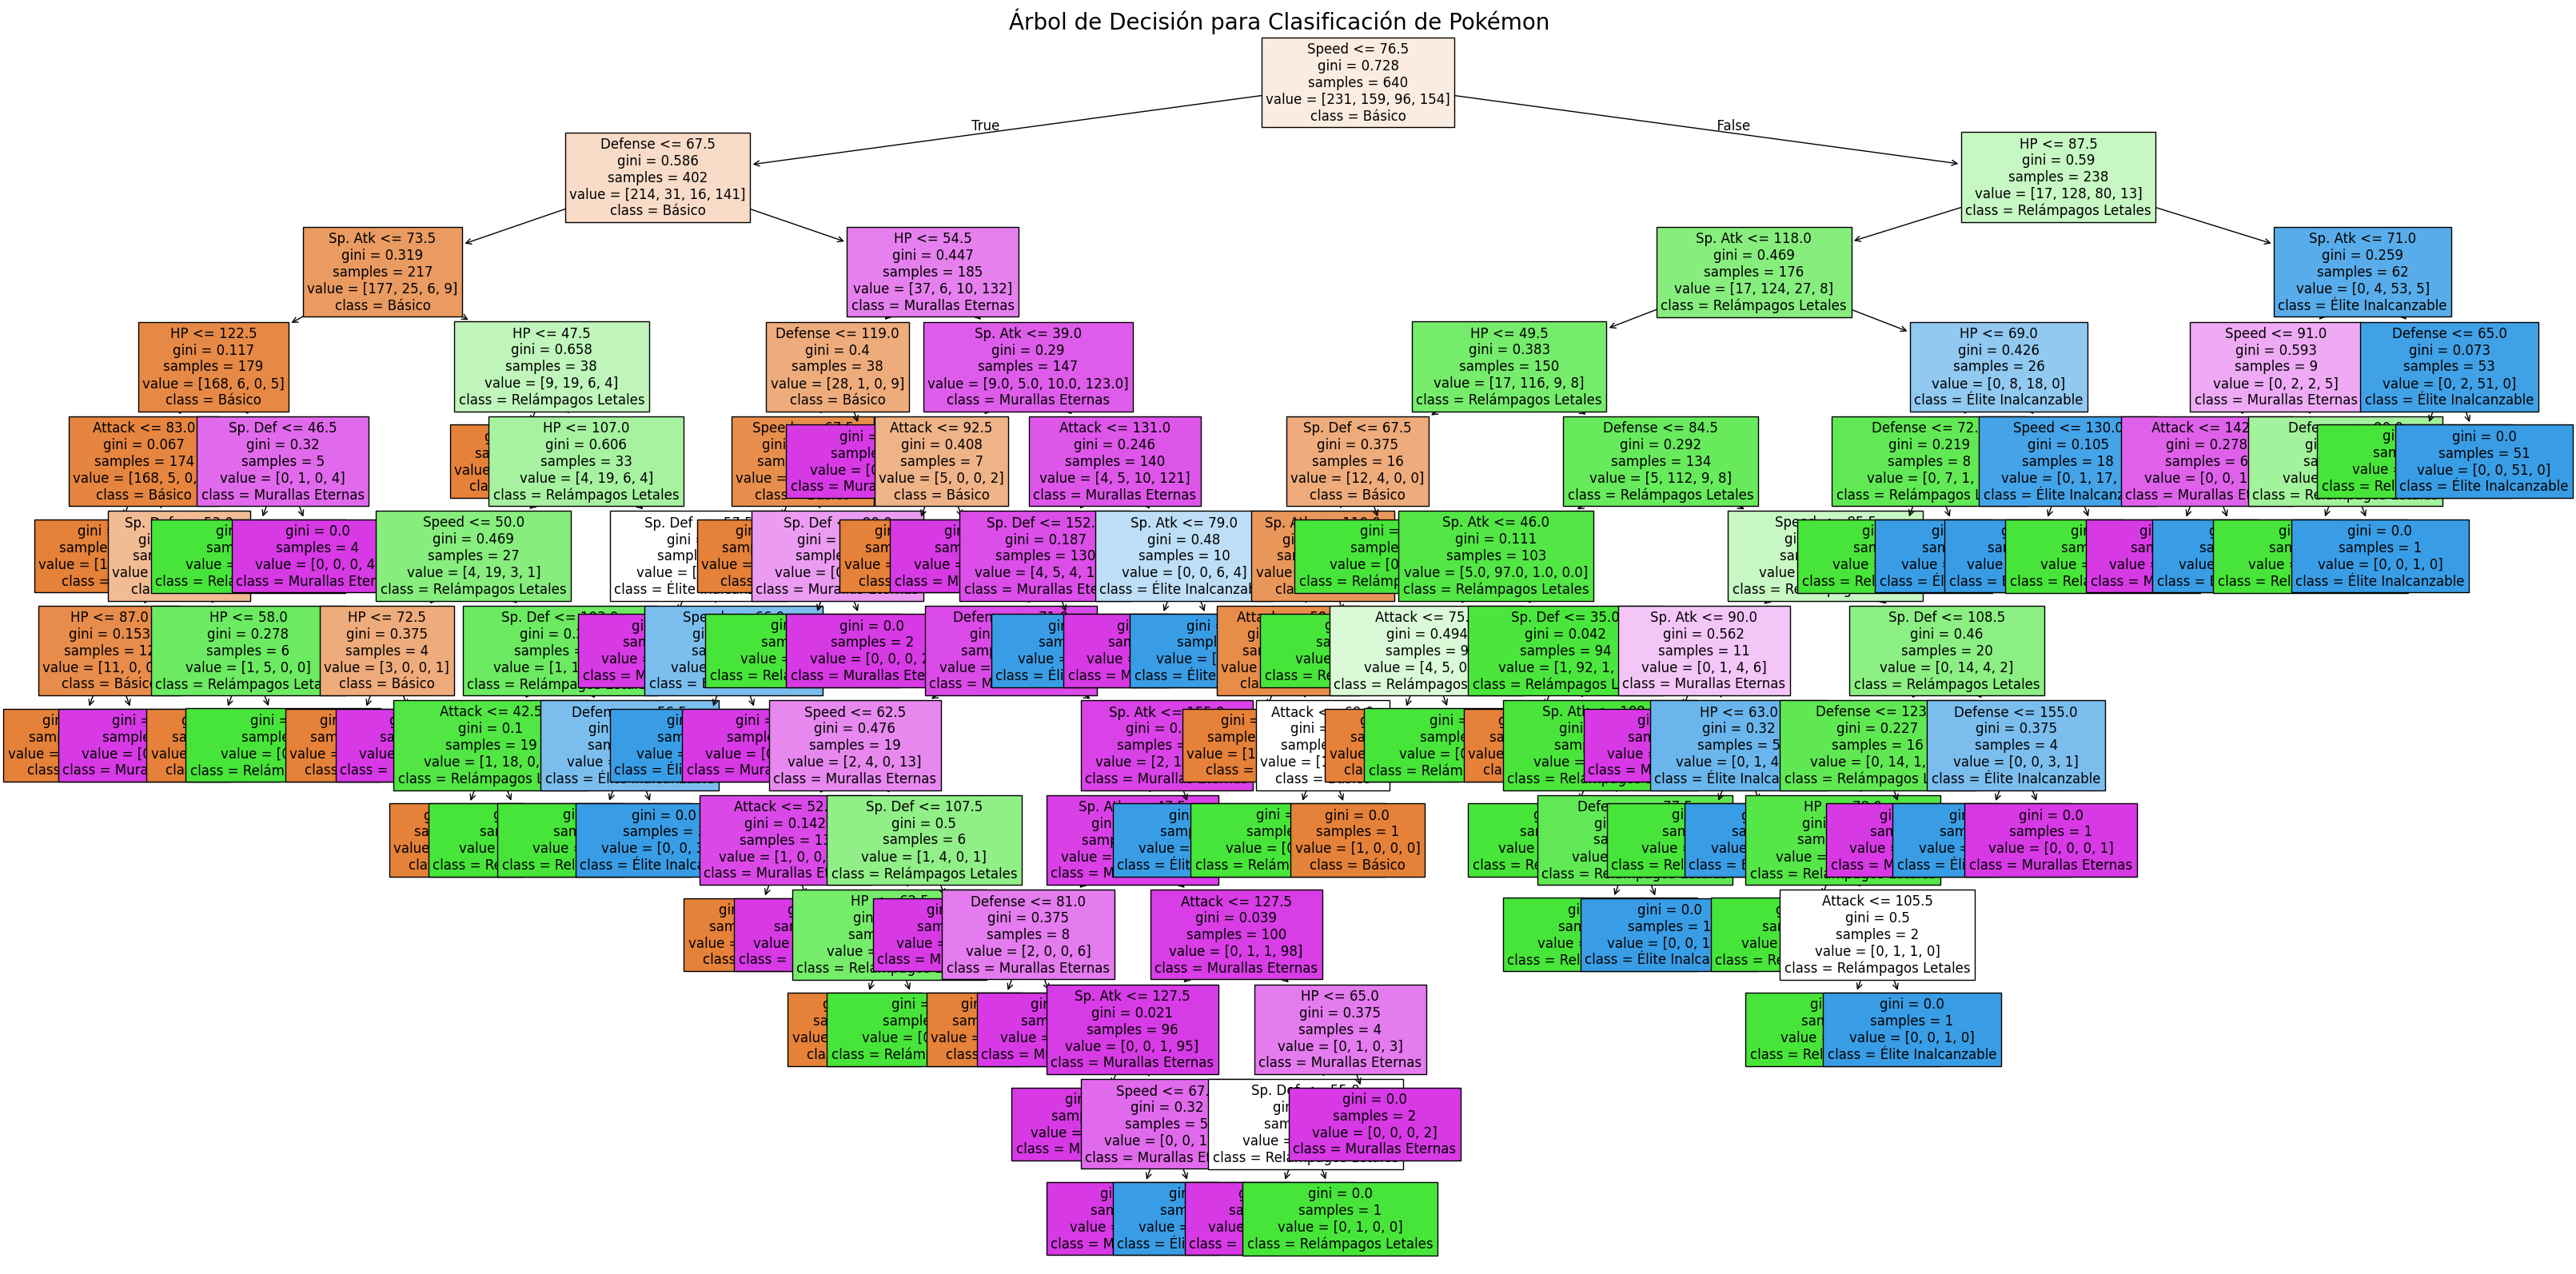

In [29]:
# Importar librerías necesarias
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Crear figura más grande
fig = plt.figure(figsize=(40, 20))  # ¡Gran tamaño para ver todo!

# Dibujar el árbol
plot_tree(modelo_arbol, 
          filled=True, 
          feature_names=X.columns, 
          class_names=["Básico", "Relámpagos Letales", "Élite Inalcanzable", "Murallas Eternas"],
          fontsize=12)

# Título bonito
plt.title("Árbol de Decisión para Clasificación de Pokémon", fontsize=20)

# Guardar como PDF
fig.savefig("arbol_decision_pokemon.pdf")

# Mostrar en Jupyter
plt.show()
